In [4]:
# %reset -f
%config Completer.use_jedi = True
# %matplotlib widget
from scipy.stats import rankdata
from sklearn.preprocessing import normalize
import graphistry
graphistry.register(api=3, username='dcolinmorgan', password='f5UwthGEF@F@xnP')
import sklearn.utils as sku
import plotly.graph_objects as go
import plotly.express as px
# import chart_studio.plotly as py
import plotly

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os,glob,sys,importlib,pickle,tqdm
from itertools import combinations#,scipy,coolbox,pybedtools,
# from scipy.stats import linregress
# from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from IPython.display import Image
import pandas as pd
import seaborn as sns
from scipy import stats
import networkx as nx
# import pyvis
# from pyvis.network import Network
import networkit as nk
# import biosppy
# from sklearn import metrics

os.chdir('/home/dcmorgan')
os.getcwd()

'/home/dcmorgan'

# bioinfo > net

In [ ]:
R0396MWT=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t',usecols=[0,1])
R0396MWT=R0396MWT[R0396MWT['R0003-CPK-DNA_Abundance-RPKs']!=0]

In [ ]:
# R0396MWT['gene']=R0396MWT['# Gene Family'].str.split('|').str[0].str.split('_').str[1].tolist()
# R0396MWT['spec']=R0396MWT['# Gene Family'].str.split('|').str[1].tolist()

# R0396MWT=R0396MWT[['spec','gene']]
# R0396MWT.spec=R0396MWT.spec.astype('str')


R0396MWTa=R0396MWT.loc[np.random.choice(R0396MWT.index, 5000, replace=False)]

In [ ]:
[len(np.unique(R0396MWTa['spec'])),
len(np.unique(R0396MWTa['gene'].astype('str')))]

In [ ]:
G=nx.from_pandas_edgelist(R0396MWTa, 'gene', 'spec', edge_attr=None, create_using=None)
# G = nx.Graph(source=['gene'],target=R0396MWT['spec'])

In [ ]:
from networkx.algorithms import bipartite
# G = nx.path_graph(4)
print(bipartite.is_bipartite(G))
# is_bipartite(G)

In [ ]:
g = nk.generators.HyperbolicGenerator(1e5).generate()
communities = nk.community.detectCommunities(g, inspect=True)

In [ ]:
%%bash
pat=R0396-MWT
awk '($3>90)' run/gcn/pat/"$pat"_proteins_o2 > "$pat"_nko
cut -f2 "$pat"_nko |cut -d "|" -f 1|cut -d "_" -f 2 > "$pat"_tmpA
cut -f2 "$pat"_nko |cut -d "|" -f 2 > "$pat"_tmpB
cut -f3 "$pat"_nko >"$pat"_tmpC
pr -mt -s, "$pat"_tmpB "$pat"_tmpA "$pat"_tmpC >"$pat"_nk
# awk '($3>90)' "$pat"_tmpD >"$pat"_nk
rm *tmp*

In [ ]:
reader = nk.graphio.EdgeListReader(',',1,'#',directed=False,continuous=False)
G = reader.read('R0396-MWT_nk')
map = reader.getNodeMap()


In [ ]:
dd = sorted(nk.centrality.DegreeCentrality(G).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [ ]:
nk.profiling.Profile.create(G).output('pdf','tmp')

In [ ]:
plmCommunities = nk.community.detectCommunities(G, algo=nk.community.PLM(G, True))

In [ ]:
print("{0} elements assigned to {1} subsets".format(plmCommunities.numberOfElements(),
plmCommunities.numberOfSubsets()))
nk.community.writeCommunities(plmCommunities, "tmp/communtiesPLM.partition")

In [ ]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

In [ ]:
coreDec = nk.centrality.CoreDecomposition(g)
coreDec.run()
nk.viztasks.drawGraph(g, node_size=[(k**2)*20 for k in coreDec.scores()])
plt.show()

# pheno

In [6]:
primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
diet=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Diet Data')
blood_stool=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='blood and stool biomarkers')
secondary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Secondary Data')
MRI=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='MRI scores')

In [7]:
uni_bact=primary[['Age','Hypertension Category by 24h BP w/o considering antihypertensive med']]
uni_bact=uni_bact.rename(columns={"Hypertension Category by 24h BP w/o considering antihypertensive med": "HT"})
# uni_bact.to_csv('data/gcn/uni_bact.txt',sep='\t')

# build code on 50 subset

In [ ]:
# relab=pd.read_csv('../../groups/cgsd/gordonq/all_hypertension/342_K2_contigsum.csv')
# relab[['p', 'c','o','f','g','s']]=pd.DataFrame(relab["Unnamed: 0"].str.split(';', expand=True).values,
#              columns=['p', 'c','o','f','g','s'])
# del relab["Unnamed: 0"]
relgene=pd.read_csv('/groups/cgsd/gordonq/LauG_Metagenomics_CPOS-200710-CJX-3455a/50_genefamilies.tsv',sep='\t')
# relgene=pd.read_csv('50_genefamilies-cpm.tsv')
# relgene=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t',nrows=100)

relgene['gene']=relgene['# Gene Family'].str.split('|').str[0]
relgene=relgene[relgene['gene']!='UniRef90_unknown']
relgene=relgene[relgene['gene']!='UNMAPPED']
relgene.index=relgene['# Gene Family']
del relgene['gene'], relgene['# Gene Family']
# relgene=relgene/relgene.sum(axis=0)

# relgene=relgene/relgene.sum(axis=0)
relgene['gen']=relgene.index.str.split('|').str[1].str.split('.').str[0].tolist()
relgene['spec']=relgene.index.str.split('.').str[1]#.str.split('.').str[0].tolist()
relgene['spec'].replace('_',' ')
relgene.index=relgene.index.str.split('|').str[0]
relgene=relgene.dropna()
# del relgene['# Gene Family']


In [ ]:
cc=relgene.groupby(['# Gene Family','spec']).sum()
# dd=relgene.groupby(['# Gene Family','gen']).sum()
cc=cc.reset_index()
# dd=dd.reset_index()
cc=cc.rename(columns={'# Gene Family':'gene'})#,'spec':0,'gene':1})

# dd=cc[['gene','spec',net]]
# dd=dd[dd[net]!=0]

check instrucitons [from here](https://stackoverflow.com/questions/23975773/how-to-compare-directed-graphs-in-networkx#54677502)
and [here](https://stackoverflow.com/questions/18261587/python-networkx-remove-nodes-and-edges-with-some-condition)

In [ ]:
relgene=pd.read_csv('data/gcn/relgene_other.txt',sep='\t')

In [ ]:
from networkx.algorithms import bipartite
ff=[]
C=[]
for i,net in enumerate(relgene.columns[1:-2]):
    pd.read_csv()
    dd=cc[['spec','gene',net]]
    dd=dd[dd[net]!=0]
    ee=nx.from_pandas_edgelist(dd,source='spec',target='gene')
    remove = [node for node,degree in dict(ee.degree()).items() if degree <10]
    ee.remove_nodes_from(remove)
    ff.append(ee)
    
    B = nx.Graph()
    B.add_nodes_from(dd['spec'], bipartite=0)
    B.add_nodes_from(dd['gene'], bipartite=1)
    B.add_edges_from(tuple(dd[['spec','gene']].itertuples(index=False, name=None)))
    remove = [node for node,degree in dict(B.degree()).items() if degree <10]
    B.remove_nodes_from(remove)
    C.append(B)

with open('data/gcn/NX_all_hypert.pkl', 'wb') as f:
    pickle.dump(ff, f)
with open('data/gcn/BX_all_hypert.pkl', 'wb') as f:
    pickle.dump(C, f)

In [ ]:
graphs = load_list_of_dicts('data/gcn/BX_all100_hypert.pkl')
len(graphs[0].edges())
# B=graphs[3]
# remove = [node for node,degree in dict(B.degree()).items() if degree <2]
# B.remove_nodes_from(remove)
# len(B.edges)

In [ ]:
measur=eval('nx.degree_centrality')
tmp=plt.hist(measur(graphs[1]),bins=20)
tmp=plt.hist(measur(graphs[0]),bins=20,alpha=.5)

In [ ]:
HT50=uni_bact[uni_bact.index.isin(relgene.columns[:-2].str.split('-').str[0])]
HT50['index']=np.arange(len(HT50))
S = [nx.clustering(graphs[i]) for i in HT50[HT50['HT']==0]['index'].values]
T = [nx.clustering(graphs[i]) for i in HT50[HT50['HT']!=0]['index'].values]

In [ ]:
non=pd.DataFrame(S).melt()
non['type']='NoHT'
non.dropna(inplace=True)
non=non[non.value!=0]
non=non[~non['variable'].str.contains('UniRef90')]
non.value=non.value/np.sum(non.value)
yes=pd.DataFrame(T).melt()
yes['type']='HT'
yes.dropna(inplace=True)
yes=yes[yes.value!=0]
yes=yes[~yes['variable'].str.contains('UniRef90')]
yes.value=yes.value/np.sum(yes.value)
df=non.append(yes)
# df=df.dropna()
df['gen']=df.variable.str.split('_').str[2]

In [ ]:
[sum(non.value),sum(yes.value)]

In [ ]:
tmp=plt.hist(non.value,log=True,bins=100)
tmp=plt.hist(yes.value,log=True,bins=100,alpha=.5)

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df[df['type']=='HT'], row="gen", hue="gen", aspect=20, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "value")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.savefig("data/gcn/degree_centrality_HT.png",dpi=300,bbox_inches = "tight")


In [ ]:
relgene=pd.read_csv('hmp_subset_genefamilies-cpm.tsv',sep='\t')

relgene['gene']=relgene['# Gene Family'].str.split('|').str[0]
relgene=relgene[relgene['gene']!='UniRef90_unknown']
relgene=relgene[relgene['gene']!='UNMAPPED']
relgene.index=relgene['# Gene Family']
del relgene['gene'], relgene['# Gene Family']
# relgene=relgene/relgene.sum(axis=0)
relgene=relgene/relgene.sum(axis=0)
relgene['gen']=relgene.index.str.split('|').str[1].str.split('.').str[0].tolist()
relgene['spec']=relgene.index.str.split('.').str[1]#.str.split('.').str[0].tolist()
relgene['spec'].replace('_',' ')
relgene.index=relgene.index.str.split('|').str[0]
relgene=relgene.dropna()


cc=relgene.groupby(['# Gene Family','spec']).sum()
# dd=relgene.groupby(['# Gene Family','gen']).sum()
cc=cc.reset_index()
# dd=dd.reset_index()
cc=cc.rename(columns={'# Gene Family':'gene'})#,'spec':0,'gene':1})


primary=pd.read_excel('data/Data Raw - Gut Microbiome Cohort Project Database - 300 Cohort v3.0_280921.xlsx',index_col=0,sheet_name='Primary Data')
uni_bact=primary[['Age','Hypertension Category by 24h BP w/o considering antihypertensive med']]
uni_bact=uni_bact.rename(columns={"Hypertension Category by 24h BP w/o considering antihypertensive med": "HT"})


# run on entire hypertension pop

In [ ]:
# %%bash 
# humann_join_tables -i /groups/cgsd/gordonq/hypertension_all/humann3_res -o hmp_subset_genefamilies.tsv --file_name genefamilies
# humann_renorm_table -i hmp_subset_genefamilies.tsv -o hmp_subset_genefamilies-cpm.tsv --units cpm

In [9]:
patt='all'
sys.path.insert(1, './run/gcn/')
import gcn_func
importlib.reload(sys.modules['gcn_func'])
from gcn_func import bip, load_list_of_dicts, meas, plotRidge,time_bar

relgene=pd.read_csv('data/gcn/relgene_all.txt',sep='\t')
graphs = load_list_of_dicts('data/gcn/BX_'+patt+'_HT.pkl')
HTXX=uni_bact[uni_bact.index.isin(relgene.columns[1:-2].str.split('-').str[0])]
HTXX['index']=np.arange(len(HTXX))


/tmp/ipykernel_50056/548540493.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HTXX['index']=np.arange(len(HTXX))


In [ ]:
# for i,net in tqdm.tqdm(enumerate(BX_graphs)):
for i,net in tqdm(enumerate(HTXX[HTXX['HT']!=5]['index'].values)):
  cc=nx.convert_matrix.to_pandas_edgelist(graphs[i])
  # cc['weight']=np.random.randn(len(cc))
  rrr=str(HTXX[HTXX['index']==i]['Age'].item())+'_'+str(HTXX[HTXX['index']==i]['HT'].item())#+'_'+str(HTXX[HTXX['index']==i]['sex'].item())
  cc.rename(columns={cc.columns[2]:rrr},inplace=True)
  if i==0:
    dd=cc
  else:
    dd=dd.merge(cc,on=['source','target'],how='outer')
# dd.dropna(how='any')

In [1188]:
# dd.set_index(['source', 'target'], inplace=True) #>> run only first time editing dd
# dd = dd/np.max(dd,axis=0)
dd=dd/np.sum(dd,axis=0)
### dd=np.argsort(dd)
noHT=dd.filter(regex='_0_').dropna(how='all')
HT1=dd.filter(regex='_1_').dropna(how='all')
HT2=dd.filter(regex='_2_').dropna(how='all')

[noHT.shape,HT1.shape,HT2.shape]

[(138518, 98), (98192, 36), (128448, 112)]

In [1189]:
noHT.columns=noHT.columns.str.split('_').str[0]
noHT=noHT.groupby(by=noHT.columns, axis=1).mean()
HT1.columns=HT1.columns.str.split('_').str[0]
HT1=HT1.groupby(by=HT1.columns, axis=1).mean()
HT2.columns=HT2.columns.str.split('_').str[0]
HT2=HT2.groupby(by=HT2.columns, axis=1).mean()
[noHT.shape,HT1.shape,HT2.shape]

[(138518, 21), (98192, 16), (128448, 23)]

In [1190]:
noHT=noHT.dropna(how='any')
HT1=HT1.dropna(how='any')
HT2=HT2.dropna(how='any')
[noHT.shape,HT1.shape,HT2.shape]

[(6412, 21), (5484, 16), (9560, 23)]

In [1194]:
# noHT=np.argsort(noHT)
noHT.reset_index(inplace=True)
jj=noHT.melt(['source','target'])
jj.rename(columns={'variable':'time'},inplace=True)
jj['t']=jj['time']
# jj['time']=jj['time'].astype('int')+1900
# jj['time'] = pd.to_datetime(jj['time'], format='%Y')
# jj=jj[jj['value']>5]
jj['species']=jj['source'].str.split('_').str[2]
# g = graphistry.edges(jj.dropna(how='any'), 'species', 'target','value')
# g.plot()

In [1192]:
[np.min(noHT.columns),np.min(HT1.columns),np.min(HT2.columns)]

['43', '45', '43']

In [1193]:
[np.max(noHT.columns),np.max(HT1.columns),np.max(HT2.columns)]

['67', '67', '67']

In [17]:
HT1[['46','47','48','52','53','56','57']]=np.nan
HT1=HT1
idx=HT1.columns.to_series().astype(float).sort_values().index
HT1=HT1[idx]
HT1=HT1.T
HT1.index=pd.to_datetime(HT1.index.astype('int')+1900,format='%Y')
HT1=HT1.T
HT1=HT1.interpolate(method='time', limit_direction='backward', axis=1)
# HT1.columns=HT1.columns
# idx=HT1.columns.to_series().astype(float).sort_values().index
# HT1=HT1[idx]
# HT1

In [1195]:
# noHT=np.argsort(noHT)
HT1.reset_index(inplace=True)
ii=HT1.melt(['source','target'])
ii.rename(columns={'variable':'time'},inplace=True)
ii['t']=ii['time']
# ii['time']=ii['time'].astype('int')+2000
# ii['time'] = pd.to_datetime(ii['time'], format='%Y')
# jj=jj[jj['value']>5]
ii['species']=ii['source'].str.split('_').str[2]
# g = graphistry.edges(jj.dropna(how='any'), 'species', 'target','value')
# g.plot()

In [19]:
# HT2=np.argsort(HT2)
HT2.reset_index(inplace=True)
kk=HT2.melt(['source','target'])
kk.rename(columns={'variable':'time'},inplace=True)
kk['t']=kk['time']
# kk['time']=kk['time'].astype('int')+1900
# kk['time'] = pd.to_datetime(kk['time'], format='%Y')
# kk=kk[kk['value']>5]
kk['species']=kk['source'].str.split('_').str[2]
# g = graphistry.edges(kk.dropna(how='any'), 'species', 'target')
# g.plot()

In [20]:
jj=jj.dropna(how='any')
kk=kk.dropna(how='any')
ll=jj.merge(kk,on=['source','target','time'],how='inner')
ll['vx']=rankdata(ll.value_x,method='min')
ll['vy']=rankdata(ll.value_y,method='min')
ll['diff']=ll['value_x']-ll['value_y']
ll['rank_diff']=ll['vx'].astype('int')-ll['vy'].astype('int')
ll['rank_diff']=np.abs(ll['rank_diff'])
ll.sort_values(by='rank_diff')
ll['species']=ll['source'].str.split('_').str[2]
# ll=ll[np.abs(ll['diff'])>1]
# g = graphistry.edges(ll.dropna(how='any'), 'species', 'target','rank_diff')
# g.plot()

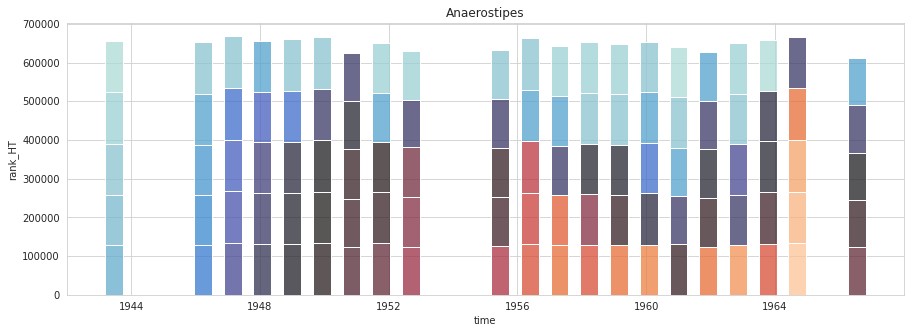

In [21]:
time_bar(jj,5,'rank','Anaerostipes')
# time_bar(jj,5,'value','all')
# time_bar(kk,5,'rank','all')
# time_bar(kk,5,'value','all')
# time_bar(ll,5,'rank_diff','all')
# time_bar(ll,5,'diff','all')

(array([1.34601e+05, 4.30000e+01, 5.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([9.73019437e-08, 1.34037499e-03, 2.68065267e-03, 4.02093036e-03,
        5.36120804e-03, 6.70148573e-03, 8.04176341e-03, 9.38204110e-03,
        1.07223188e-02, 1.20625965e-02, 1.34028742e-02]),
 <BarContainer object of 10 artists>)

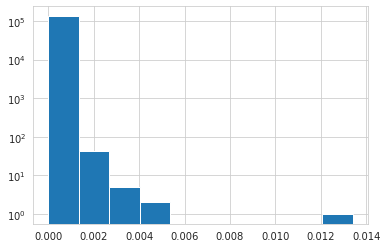

In [22]:
plt.hist(jj.value,log=True)

In [32]:
XX=10
labels,levels=pd.factorize(jj['target'])
jj['prot_id']=labels
jj['t']=jj['time'].astype('str').str.split('-').str[0]
labels,levels=pd.factorize(jj['t'])
jj['t']=labels
data=jj[['species','prot_id','time','t','value']]
df=data.copy()
grouped = data.groupby('prot_id')

def get_next_clus(x): return x['species'].shift(-1)

data["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)


# df = data[['species','target','t','value']]#.sort_values(['time'], ascending=[True]).groupby(['species','time']).max(5)
jeff=pd.DataFrame(df.groupby(['species','t'])['value'].nlargest(XX))
jeff.reset_index(inplace=True)

jeffA=data.loc[jeff['level_2']]

/tmp/ipykernel_50056/1710408779.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["next_clus"] = grouped.apply(


In [33]:
grouped = pd.DataFrame(jeffA.groupby(['species', 't'])['prot_id'].apply(list).groupby(level=0).apply(list))
jeff=grouped.explode('prot_id')
jeff.reset_index(inplace=True)

In [184]:
np.unique(data.species)

array(['Agathobaculum', 'Anaerostipes', 'Bacteroides', 'Bifidobacterium',
       'Blautia', 'Dorea', 'Escherichia', 'Eubacterium',
       'Faecalibacterium', 'Flavonifractor', 'Parabacteroides',
       'Roseburia', 'Ruminococcus', 'Ruthenibacterium', 'Streptococcus'],
      dtype=object)

In [34]:
jeff2=jeff[jeff['species']=='Agathobaculum'].explode('prot_id')
# jeff2['prot_id']#.str.split(',')
jeff3=pd.DataFrame(jeff2['prot_id'].to_numpy().reshape(int(len(jeff2)/21),21))
# jeff3.index='Agathobaculum'

(array([ 9.,  1.,  2.,  5.,  1.,  2.,  0.,  1.,  1.,  3., 12.,  1.,  0.,
         9., 19.,  1.,  5.,  4.,  0.,  2., 12.,  1.,  1., 14.,  0.,  3.,
         1.,  8.,  4.,  1.,  1.,  0., 17.,  2.,  1.,  1., 13.,  0.,  6.,
         6.,  1., 10.,  3.,  0.,  1.,  1.,  2., 10.,  8.,  4.]),
 array([ 0.  ,  0.84,  1.68,  2.52,  3.36,  4.2 ,  5.04,  5.88,  6.72,
         7.56,  8.4 ,  9.24, 10.08, 10.92, 11.76, 12.6 , 13.44, 14.28,
        15.12, 15.96, 16.8 , 17.64, 18.48, 19.32, 20.16, 21.  , 21.84,
        22.68, 23.52, 24.36, 25.2 , 26.04, 26.88, 27.72, 28.56, 29.4 ,
        30.24, 31.08, 31.92, 32.76, 33.6 , 34.44, 35.28, 36.12, 36.96,
        37.8 , 38.64, 39.48, 40.32, 41.16, 42.  ]),
 <BarContainer object of 50 artists>)

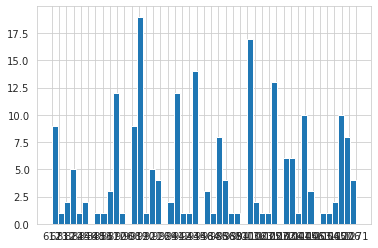

In [35]:
plt.hist((np.sort(jeff3.melt()['value'])).astype('str'),bins=50)#.value_counts())

<BarContainer object of 43 artists>

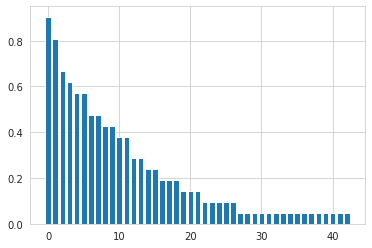

In [36]:
plt.bar(x=np.arange(len((np.unique(jeff3.melt()['value'])))),height=jeff3.melt()['value'].value_counts()/21)

In [875]:
jj['t']=jj['time'].astype('str').str.split('-').str[0]
labels,levels=pd.factorize(jj['t'])
jj['t']=labels
data=jj[['species','target','time','t','value']]
df=data.copy()
grouped = data.groupby('target')
XX=10
def get_next_clus(x): return x['species'].shift(-1)

data["next_clus"] = grouped.apply(
     lambda x: get_next_clus(x)).reset_index(0, drop=True)

# species=['Agathobaculum','Bacteroides']
# df = data[['species','target','t','value']]#.sort_values(['time'], ascending=[True]).groupby(['species','time']).max(5)
jeff=pd.DataFrame(df.groupby(['species','t'])['value'].nlargest(XX))
jeff.reset_index(inplace=True)

jeffA=data.loc[jeff['level_2']]
tim_len=len(np.unique(jeffA['t']))
grouped = pd.DataFrame(jeffA.groupby(['species', 't'])['target'].apply(list).groupby(level=0).apply(list))
jeff=grouped.explode('target')
jeff.reset_index(inplace=True)
# jeff=jeff[(jeff['species']!='Escherichia')&(jeff['species']!='Streptococcus')]
# if species!='all':
#     jeffA=jeff[jeff['species']==species]
JJ=pd.DataFrame()
rr=[]
# for q,ee in enumerate(np.unique(jeff.species)[::-1]):
for q,ee in enumerate(sku.shuffle(np.unique(jeff.species))):

    jeff2=jeffA[jeffA['species']==ee].explode('target')
    # jeff2['prot_id']#.str.split(',')
    dd=pd.DataFrame(jeff2['target'].to_numpy().reshape(int(len(jeff2)/tim_len),tim_len))
    # jeff3.index='Agathobaculum'
    # plt.figure(figsize=(15,5))
    # labels,levels=pd.factorize(jeff3.melt()['value'])
    # jj['prot_id']=labels
    # sns.heatmap(pd.factorize(jeff3))
    # cc=pd.DataFrame(np.array(labels).reshape(XX,tim_len))
    rr=np.append(rr, ee)
#     cc.iloc
    # cc.loc[(q+1)*XX]=0
    if len(dd.melt())==(tim_len*XX):
        JJ=JJ.append(dd)


# sns.heatmap(cc)

/tmp/ipykernel_50056/3786259440.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_50056/2532502708.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/dcmorgan/.conda/envs/mypy3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



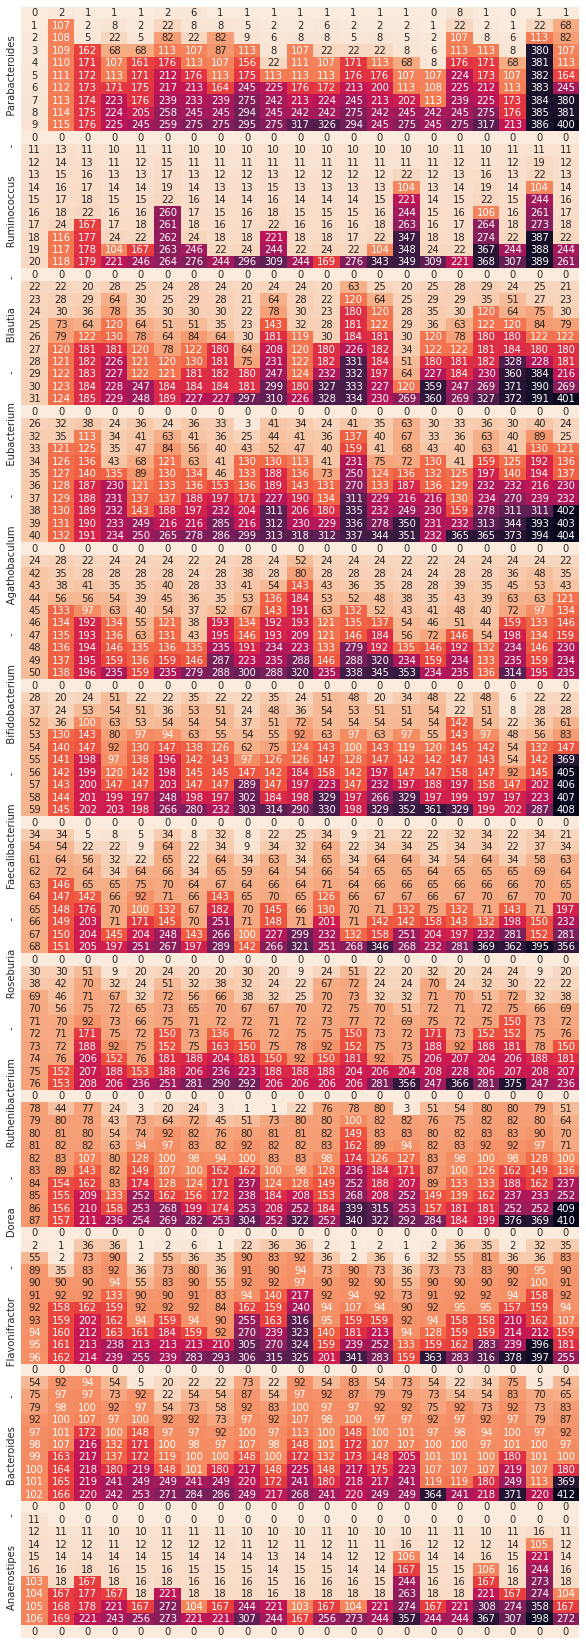

NameError: name 'Path' is not defined

In [1173]:
data=jj[['species','target','time','t','value']]
# df=data.copy()
# data.reset_index(inplace=True)
data['sum']=pd.DataFrame(data.groupby(['species','t','target'])['value'].transform('sum'))
# jeff.reset_index(inplace=True)
del data['value']
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True)
del data['index'],data['time']
jeff=pd.DataFrame(data.groupby(['species','t'])['sum'].nlargest(XX))
jeff.reset_index(inplace=True)

jeffA=data.iloc[jeff['level_2']]

# JJ
# jeffA.sort_values(by='t')
JJ=pd.DataFrame()
rr=[]
for q,ee in enumerate(sku.shuffle(np.unique(jeff.species))):
    jeff2=jeffA[jeffA['species']==ee]#.explode('target')
    dd=pd.DataFrame(jeff2['target'].to_numpy().reshape(int(len(jeff2)/tim_len),tim_len,order='F'))
    
    if len(dd.melt())==(tim_len*XX):
        JJ=JJ.append(dd)
        rr=np.append(rr, ee)
jeffA=jeffA.sort_values(['species', 't'], ascending=[True, True])

labels,levels=pd.factorize((JJ.melt()['value']))
cc=pd.DataFrame(np.array(labels).reshape((XX)*len(rr),tim_len,order='F'))

for i in np.arange(0,len(cc),XX+1):
    for col in cc:
        cc.iloc[i:i+XX,col] = cc.iloc[i:i+XX,col].sort_values(ignore_index=True)
        cc.loc[i+XX]=0

plt.figure(figsize=(10,30))
ax=sns.heatmap(cc,cmap='rocket_r',annot=True, fmt="d",cbar=False,xticklabels=False,
               yticklabels=False).set(ylabel='         -         '.join(rr))

plt.show()
Path("data/gcn/img/"+cc).mkdir(parents=True, exist_ok=True)
plt.savefig("data/gcn/img/rev_all_10.png",dpi=300,bbox_inches = "tight")

In [1174]:
data=kk[['species','target','time','t','value']]
# df=data.copy()
# data.reset_index(inplace=True)
data['sum']=pd.DataFrame(data.groupby(['species','t','target'])['value'].transform('sum'))
# jeff.reset_index(inplace=True)
del data['value']
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True)
del data['index'],data['time']
jeff=pd.DataFrame(data.groupby(['species','t'])['sum'].nlargest(XX))
jeff.reset_index(inplace=True)

jeffA=data.iloc[jeff['level_2']]

# JJ
# jeffA.sort_values(by='t')
JJ=pd.DataFrame()
rr=[]
for q,ee in enumerate(sku.shuffle(np.unique(jeff.species))):
    jeff2=jeffA[jeffA['species']==ee]#.explode('target')
    dd=pd.DataFrame(jeff2['target'].to_numpy().reshape(int(len(jeff2)/tim_len),tim_len,order='F'))
    
    if len(dd.melt())==(tim_len*XX):
        JJ=JJ.append(dd)
        rr=np.append(rr, ee)
jeffA=jeffA.sort_values(['species', 't'], ascending=[True, True])

labels,levels=pd.factorize((JJ.melt()['value']))
cc=pd.DataFrame(np.array(labels).reshape((XX)*len(rr),tim_len,order='F'))

for i in np.arange(0,len(cc),XX+1):
    for col in cc:
        cc.iloc[i:i+XX,col] = cc.iloc[i:i+XX,col].sort_values(ignore_index=True)
        cc.loc[i+XX]=0

plt.figure(figsize=(10,30))
ax=sns.heatmap(cc,cmap='rocket_r',annot=True, fmt="d",cbar=False,xticklabels=False,
               yticklabels=False).set(ylabel='         -         '.join(rr))

plt.show()
Path("data/gcn/img/"+cc).mkdir(parents=True, exist_ok=True)
plt.savefig("data/gcn/img/rev_all_10.png",dpi=300,bbox_inches = "tight")

/tmp/ipykernel_50056/3124726841.py:1: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



IndexError: invalid index to scalar variable.

In [1175]:
kk

7

# Sankey start

In [44]:
# Working on the nodes_dict

all_events = list(data.species.unique())

# Create a set of colors that you'd like to use in your plot.
palette = ['50BE97', 'E4655C', 'FBEEAC', '3E5066',
           'BFD6DE', 'FCC865', '353A3E', 'E6E6E6',
          'E4655C', 'FBEEAC', '3E5066',
           'BFD6DE', 'FCC865', '353A3E', 'E6E6E6']
#  Here, I passed the colors as HEX, but we need to pass it as RGB. This loop will convert from HEX to RGB:
for i, col in enumerate(palette):
    palette[i] = tuple(int(col[i:i+2], 16) for i in (0, 2, 4))

# Append a Seaborn complementary palette to your palette in case you did not provide enough colors to style every event
complementary_palette = sns.color_palette("deep", len(all_events) - len(palette))
if len(complementary_palette) > 0:
    palette.extend(complementary_palette)

output = dict()
output.update({'nodes_dict': dict()})

i = 0
for t in data.t.unique(): # For each tri of clus...
    # Create a new key equal to the tri...
    output['nodes_dict'].update(
        {t: dict()}
    )
    
    # Look at all the events that were done at this step of the funnel...
    all_events_at_this_rank = data[data.t ==
                                   t].species.unique()
    
    # Read the colors for these events and store them in a list...
    tri_palette = []
    for clus in all_events_at_this_rank:
        tri_palette.append(palette[list(all_events).index(clus)])
    
    # Keep trace of the events' names, colors and indices.
    output['nodes_dict'][t].update(
        {
            'sources': list(all_events_at_this_rank),
            'color': tri_palette,
            'sources_index': list(range(i, i+len(all_events_at_this_rank)))
        }
    )
    # Finally, increment by the length of this rank's available clus to make sure next indices will not be chosen from existing ones
    i += len(output['nodes_dict'][t]['sources_index'])

In [45]:
# Working on the links_dict

output.update({'links_dict': dict()})

# Group the DataFrame by pat_epi and tri


grouped = data.groupby(['prot_id', 't'])

# Define a function to read the souces, targets, values species to next_clus:
def update_source_target(user):
    try:
        # user.name[0] is the user's spec; user.name[1] is the time
        # 1st we retrieve the source and target's indices from nodes_dict
        source_index = output['nodes_dict'][user.name[1]]['sources_index'][output['nodes_dict']
                                                                           [user.name[1]]['sources'].index(user['species'].values[0])]
        target_index = output['nodes_dict'][user.name[1] + 1]['sources_index'][output['nodes_dict']
                                                                               [user.name[1] + 1]['sources'].index(user['next_clus'].values[0])]
        # print(user.name)
         # If this source is already in links_dict...
        if source_index in output['links_dict']:
            # ...and if this target is already associated to this source...
            if target_index in output['links_dict'][source_index]:
                # ...then we increment the count of users with this source/target pair by 1
                output['links_dict'][source_index][target_index]['unique_users'] += 1
            # ...but if the target is not already associated to this source...
            else:
                # ...we create a new key for this target, for this source, and initiate it with 1 user and the time from source to target
                output['links_dict'][source_index].update({target_index:
                                                           dict(
                                                               {'unique_users': 1}
                                                            )
                                                           })
        # ...but if this source isn't already available in the links_dict, we create its key and the key of this source's target, and we initiate it with 1 user and the time from source to target
        else:
            output['links_dict'].update({source_index: dict({target_index: dict(
                {'unique_users': 1})})})
    except Exception as e:
        pass

# Apply the function to your grouped Pandas object:
grouped.apply(lambda user: update_source_target(user)) 




""


In [104]:
targets = []
sources = []
values = []

for source_key, source_value in output['links_dict'].items():
    for target_key, target_value in output['links_dict'][source_key].items():
        sources.append(source_key)
        targets.append(target_key)
        values.append(target_value['unique_users'])
        
labels = []
colors = []

for key, value in output['nodes_dict'].items():
    labels = labels + list(output['nodes_dict'][key]['sources']) 
    colors = colors + list(output['nodes_dict'][key]['color'])
for idx, color in enumerate(colors):
    colors[idx] = "rgb" + str(color) + ""
[len(targets),len(sources),len(values)]

[1140, 1140, 1140]

In [105]:
values = [ -x if x<2 else x for x in values]

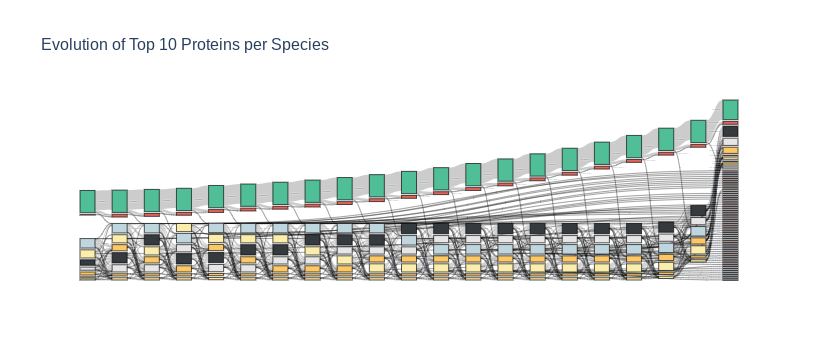

In [106]:
# label = ["{} {}".format(node1_name, node1_val), "{} {}".format(node2_name, node2_val) ...]
fig = go.Figure(data=[go.Sankey(
    node=dict(
        thickness=15,  # default is 20
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        # hovertemplate='%{link.label}.<br />',
        # hovertemplate='%{value} top10 proteins went from %{source.label} to %{target.label}.<br />',
    ))])

fig.update_layout(autosize=True, title=dict(text="Evolution of Top "+str(XX)+" Proteins per Species", font_size=16),
                  font=dict(size=1, family="Arial"), plot_bgcolor='white')


In [104]:
import urllib, json
url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data2 = json.loads(response.read())

In [105]:
label =  data2['data'][0]['node']['label']
color =  data2['data'][0]['node']['color']

source =  data2['data'][0]['link']['source']
target =  data2['data'][0]['link']['target']
value =  data2['data'][0]['link']['value']
label =  data2['data'][0]['link']['label']

## network properties

In [ ]:
# for net in dd:
#     df=meas(measur,uni_bact,relgene,graphs)
dd=['nx.degree_centrality','nx.betweenness_centrality','nx.closeness_centrality','nx.node_redundancy','nx.communicability']

df=[meas(measur,uni_bact,relgene,graphs,patt) for measur in dd]
# df=[print(measur) for measur in dd]

In [ ]:
# from joblib import Parallel
dd=['nx.degree','nx.harmonic_centrality','nx.communicability','nx.betweenness_centrality','nx.degree_centrality','nx.closeness_centrality','nx.node_redundancy']
df=Parallel(n_jobs=7) (meas(measur,uni_bact,relgene,graphs) for measur in dd)
# C=[tup[1] for tup in ff]
# df=[tup[0] for tup in df]

In [ ]:
measur='nx.degree'
HTXX=uni_bact[uni_bact.index.isin(relgene.columns[1:-2].str.split('-').str[0])]
HTXX['index']=np.arange(len(HTXX))
measur=eval(measur)
S = [measur(graphs[i]) for i in HTXX[HTXX['HT']==0]['index'].values[0:3]]
T = [measur(graphs[i]) for i in HTXX[HTXX['HT']!=0]['index'].values[0:3]]
if measur!=nx.degree:
    non=pd.DataFrame(S).melt()
    yes=pd.DataFrame(T).melt()
elif measur==nx.degree:
    non=pd.DataFrame(S.pop())
    non=non.rename(columns={0:'variable',1:'value'})
    yes=pd.DataFrame(T.pop())
    yes=yes.rename(columns={0:'variable',1:'value'})

# non=pd.DataFrame(S).melt()
non['type']='NoHT'
non.dropna(inplace=True)
non=non[non.value!=0]
non=non[~non['variable'].str.contains('UniRef90')]
non.value=non.value/np.sum(non.value)

yes['type']='HT'
yes.dropna(inplace=True)
yes=yes[yes.value!=0]
yes=yes[~yes['variable'].str.contains('UniRef90')]
yes.value=yes.value/np.sum(yes.value)
df=non.append(yes)
df=df.dropna()
df['gen']=df.variable.str.split('_').str[2]

# Ian

In [460]:
LF=pd.read_csv('common_features.lipidfinder.metaboanalyst.csv',index_col=0)
pipe=pd.read_csv('common_features.pipeline.metaboanalyst.csv',index_col=0)
raw=pd.read_csv('common_features.raw.metaboanalyst.csv',index_col=0)

In [461]:
del LF['Group'], pipe['Group']

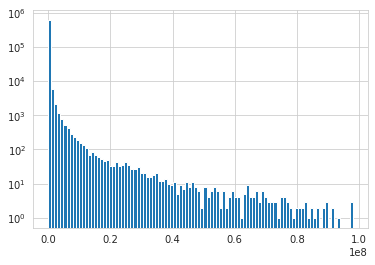

In [473]:
tmp=plt.hist(np.abs(LF-raw).melt().value,log=True,bins=100)

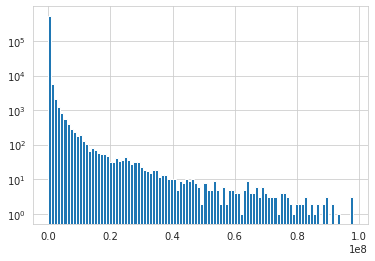

In [474]:
tmp=plt.hist(np.abs(LF-pipe).melt().value,log=True,bins=100)

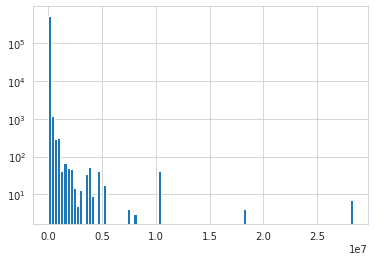

In [475]:
tmp=plt.hist(np.abs(raw-pipe).melt().value,log=True,bins=100)